In [1]:
pip install numpy==1.23.5 seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# sc master - running locally
sc.master
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

In [4]:
sc = spark.sparkContext

In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, BooleanType

dataPath = "/CA1/data/TMDB_movie_dataset_v2.csv"
# schema = StructType([
#     StructField("id", IntegerType(), True),
#     StructField("title", StringType(), True),
#     StructField("vote_average", FloatType(), True),
#     StructField("vote_count", IntegerType(), True),
#     StructField("status", StringType(), True),
#     StructField("release_date", DateType(), True),
#     StructField("runtime", IntegerType(), True),
#     StructField("adult", BooleanType(), True),
#     StructField("budget", IntegerType(), True),
#     StructField("popularity", FloatType(), True),
# ])
moviesDF = spark.read.option("multiline", "true").option("quote", '"').option("header", "true").option("escape", "\\").option("escape", '"').csv(dataPath ,header=True)

moviesDF = moviesDF.withColumn("popularity", moviesDF["popularity"].cast("float"))
moviesDF = moviesDF.withColumn("id", moviesDF["id"].cast("int"))
moviesDF = moviesDF.withColumn("vote_average", moviesDF["vote_average"].cast("float"))
moviesDF = moviesDF.withColumn("vote_count", moviesDF["vote_count"].cast("int"))
moviesDF = moviesDF.withColumn("release_date", moviesDF["release_date"].cast("date"))
moviesDF = moviesDF.withColumn("runtime", moviesDF["runtime"].cast("int"))
moviesDF = moviesDF.withColumn("adult", moviesDF["adult"].cast("boolean"))
moviesDF = moviesDF.withColumn("budget", moviesDF["budget"].cast("int"))
moviesDF = moviesDF.withColumn("revenue", moviesDF["revenue"].cast("int"))

moviesDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)



In [6]:
moviesDF.select("title", "genres").show(2)

+------------+--------------------+
|       title|              genres|
+------------+--------------------+
|   Inception|Action, Science F...|
|Interstellar|Adventure, Drama,...|
+------------+--------------------+
only showing top 2 rows



In [7]:
moviesDF.count()

934745

In [8]:
numericalColumns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity']

In [9]:
moviesDF.select(numericalColumns).toPandas().describe()

,vote_average,vote_count,revenue,runtime,budget,popularity
count,934745.000000,934745.000000,9.347410e+05,934745.000000,9.347450e+05,934745.000000
mean,2.232957,22.939624,7.671959e+05,51.889123,3.061706e+05,1.424210
std,3.152949,351.094674,1.716210e+07,62.425681,5.058921e+06,8.349914
min,0.000000,0.000000,-1.200000e+01,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000e+00,2.000000,0.000000e+00,0.600000
50%,0.000000,0.000000,0.000000e+00,39.000000,0.000000e+00,0.600000
75%,5.294000,1.000000,0.000000e+00,90.000000,0.000000e+00,0.958000
max,10.000000,34495.000000,2.068224e+09,14400.000000,8.880000e+08,2994.356934


### Missing Values

In [10]:
import pyspark.sql.functions as fn

moviesDF.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_miss')
    for c in moviesDF.columns
]).toPandas().head()

,id_miss,title_miss,vote_average_miss,vote_count_miss,status_miss,release_date_miss,revenue_miss,runtime_miss,adult_miss,backdrop_path_miss,...,original_language_miss,original_title_miss,overview_miss,popularity_miss,poster_path_miss,tagline_miss,genres_miss,production_companies_miss,production_countries_miss,spoken_languages_miss
0,0.0,0.000012,0.0,0.0,0.0,0.090429,0.000004,0.0,0.0,0.705277,...,0.0,0.000012,0.173734,0.0,0.256717,0.854446,0.351958,0.511231,0.387607,0.381594


In [11]:
moviesDF.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in moviesDF.columns]).toPandas().head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,0,11,0,0,0,84528,4,0,0,659254,...,0,11,162397,0,239965,798689,328991,477871,362314,356693


### Correlation

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

# intFields = spark.sql("SELECT vote_average, vote_count, revenue, runtime, budget, popularity, release_year FROM movies")
def plotCorrelation (df): 
    intFields = moviesDF.select(numericalColumns)

    # Fill all the null values with 0 so that it wont cause an error in the correlation matrix
    intFields = intFields.fillna(0)

    assembler = VectorAssembler(inputCols = numericalColumns, outputCol = "features")
    dfAssembled = assembler.transform(intFields).select("features")

    matrix = Correlation.corr(dfAssembled, "features").collect()[0][0]
    corrMatrix = matrix.toArray().tolist()

    # corrDF = spark.createDataFrame(corrMatrix, cols)
    corrDF = pd.DataFrame(data = corrMatrix, columns = numericalColumns)

    plt.figure(figsize = (16,5))
    sns.heatmap(corrDF,
                xticklabels = corrDF.columns.values,
                yticklabels = corrDF.columns.values,
                cmap = "Greens",
                annot = True
               )

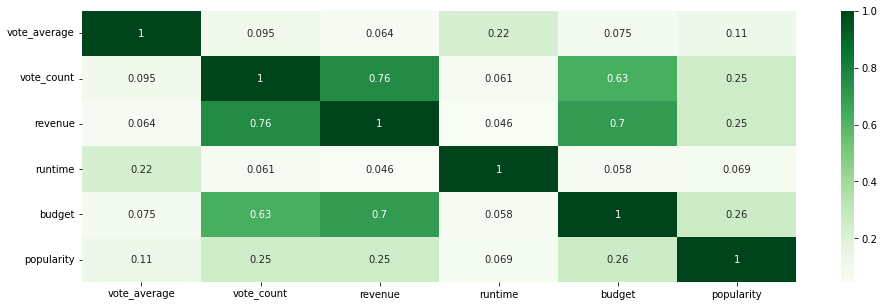

In [13]:
plotCorrelation(moviesDF)

### Histogram

In [14]:
def plotHistogram (df):
    numBins = 20

    for column in numericalColumns:
        tempPanda = df.select(column).toPandas()

        plt.figure(figsize = (8,6))
        sns.histplot(data = tempPanda, x = column, bins = numBins)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {column}")
        plt.show()

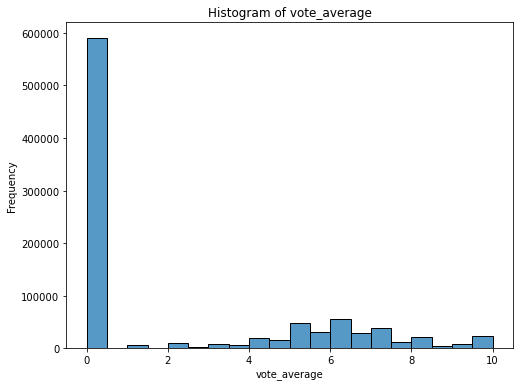

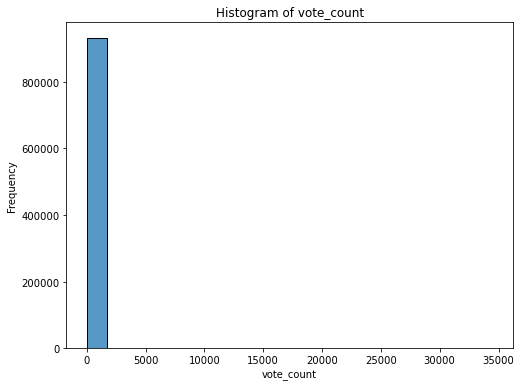

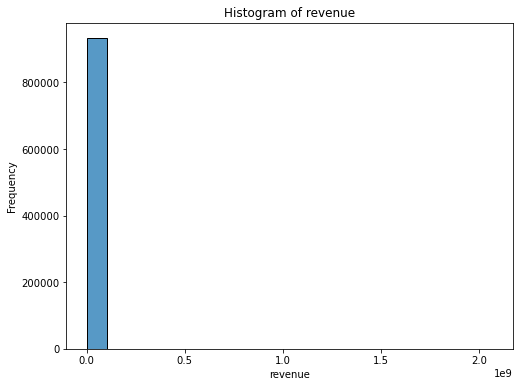

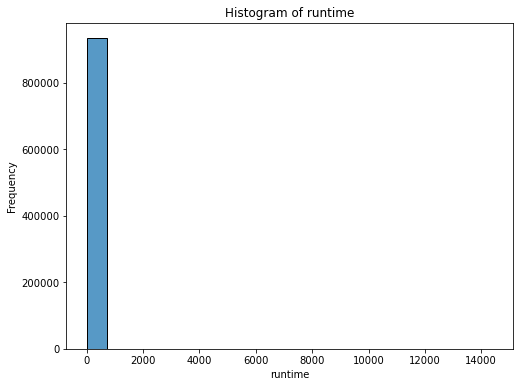

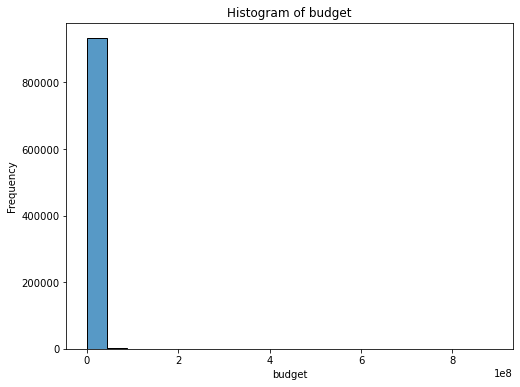

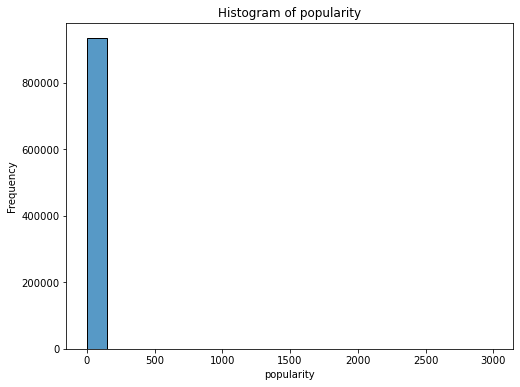

In [15]:
plotHistogram (moviesDF)

### Data Manipulation and Feature Extraction

In [16]:
from pyspark.sql.functions import year
moviesDF = moviesDF.withColumn("release_year", year("release_date"))
numericalColumns.append("release_year")

moviesDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- homepage: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- release_year: integer (

In [17]:
# Drop columns that will not be used
moviesDF = moviesDF.drop("id")
# moviesDF = moviesDF.drop("title")
moviesDF = moviesDF.drop("adult")
moviesDF = moviesDF.drop("backdrop_path")
moviesDF = moviesDF.drop("homepage")
moviesDF = moviesDF.drop("imdb_id")
moviesDF = moviesDF.drop("original_language")
moviesDF = moviesDF.drop("original_title")
moviesDF = moviesDF.drop("homepage")
moviesDF = moviesDF.drop("overview")
moviesDF = moviesDF.drop("poster_path")
moviesDF = moviesDF.drop("tagline")
moviesDF = moviesDF.drop("production_companies")
moviesDF = moviesDF.drop("production_countries")
moviesDF = moviesDF.drop("spoken_languages")
moviesDF = moviesDF.drop("release_date")
moviesDF.toPandas().head()

,title,vote_average,vote_count,status,revenue,runtime,budget,popularity,genres,release_year
0,Inception,8.364,34495,Released,8.255328e+08,148,160000000,83.952003,"Action, Science Fiction, Adventure",2010.0
1,Interstellar,8.417,32571,Released,7.017292e+08,169,165000000,140.240997,"Adventure, Drama, Science Fiction",2014.0
2,The Dark Knight,8.512,30619,Released,1.004558e+09,152,185000000,130.643005,"Drama, Action, Crime, Thriller",2008.0
3,Avatar,7.573,29815,Released,NaN,162,237000000,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009.0
4,The Avengers,7.710,29166,Released,1.518816e+09,143,220000000,98.082001,"Science Fiction, Action, Adventure",2012.0


In [18]:
moviesDF.select("release_year").toPandas().describe()

,release_year
count,850217.000000
mean,1998.653910
std,26.748655
min,1865.000000
25%,1988.000000
50%,2009.000000
75%,2018.000000
max,2099.000000


In [19]:
moviesDF.where("popularity > 2990")

title,vote_average,vote_count,status,revenue,runtime,budget,popularity,genres,release_year
Blue Beetle,7.139,1023,Released,124818235,128,120000000,2994.357,"Action, Science F...",2023


In [20]:
allMoviesDF = moviesDF

moviesDF = moviesDF.where("popularity > 0 AND genres IS NOT NULL AND runtime > 0 AND status = 'Released' AND release_year > 1900")
moviesDF.count()
#spark.sql("SELECT COUNT(release_year) FROM movies WHERE popularity > 0 AND genres IS NOT NULL AND runtime > 0 AND status = 'Released' AND release_year > 1980").show()

477957

In [21]:
moviesDF.toPandas().describe()

,vote_average,vote_count,revenue,runtime,budget,popularity,release_year
count,477957.000000,477957.000000,4.779530e+05,477957.000000,4.779570e+05,477957.000000,477957.000000
mean,3.192882,44.415774,1.474315e+06,69.572265,5.738069e+05,2.092083,1997.926631
std,3.252265,490.023659,2.359842e+07,60.881496,6.739161e+06,11.475749,26.740034
min,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,0.600000,1901.000000
25%,0.000000,0.000000,0.000000e+00,25.000000,0.000000e+00,0.600000,1985.000000
50%,3.000000,1.000000,0.000000e+00,80.000000,0.000000e+00,0.713000,2009.000000
75%,6.016000,4.000000,0.000000e+00,96.000000,0.000000e+00,1.492000,2018.000000
max,10.000000,34495.000000,2.068224e+09,14400.000000,8.880000e+08,2994.356934,2025.000000


In [22]:
moviesDF.printSchema()

root
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- budget: integer (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- release_year: integer (nullable = true)



In [23]:
moviesDF.toPandas().head()

,title,vote_average,vote_count,status,revenue,runtime,budget,popularity,genres,release_year
0,Inception,8.364,34495,Released,8.255328e+08,148,160000000,83.952003,"Action, Science Fiction, Adventure",2010
1,Interstellar,8.417,32571,Released,7.017292e+08,169,165000000,140.240997,"Adventure, Drama, Science Fiction",2014
2,The Dark Knight,8.512,30619,Released,1.004558e+09,152,185000000,130.643005,"Drama, Action, Crime, Thriller",2008
3,Avatar,7.573,29815,Released,NaN,162,237000000,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009
4,The Avengers,7.710,29166,Released,1.518816e+09,143,220000000,98.082001,"Science Fiction, Action, Adventure",2012


### Missing values for new dataset

In [24]:
moviesDF.select([fn.count(fn.when(fn.col(c) == 0, c)).alias(c) for c in numericalColumns]).toPandas().head()

,vote_average,vote_count,revenue,runtime,budget,popularity,release_year
0,222483,222380,461166,0,444139,0,0


In [25]:
moviesDF = moviesDF.drop("vote_average")
moviesDF = moviesDF.drop("vote_count")
moviesDF = moviesDF.drop("revenue")
moviesDF = moviesDF.drop("budget")

numericalColumns.remove("vote_average")
numericalColumns.remove("vote_count")
numericalColumns.remove("revenue")
numericalColumns.remove("budget")

In [26]:
moviesDF.toPandas().head()

,title,status,runtime,popularity,genres,release_year
0,Inception,Released,148,83.952003,"Action, Science Fiction, Adventure",2010
1,Interstellar,Released,169,140.240997,"Adventure, Drama, Science Fiction",2014
2,The Dark Knight,Released,152,130.643005,"Drama, Action, Crime, Thriller",2008
3,Avatar,Released,162,79.931999,"Action, Adventure, Fantasy, Science Fiction",2009
4,The Avengers,Released,143,98.082001,"Science Fiction, Action, Adventure",2012


### Outliers

In [27]:
# Check for outliers
bounds = {}

for col in numericalColumns:
    quantiles = moviesDF.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
    
bounds

{'runtime': [-81.5, 202.5],
 'popularity': [-0.7994999289512634, 2.932499945163727],
 'release_year': [1935.5, 2067.5]}

In [28]:
moviesDF.select([
    (
        (moviesDF[c] < bounds[c][0]) | 
        (moviesDF[c] > bounds[c][1])
    ).alias(c + '_o') for c in numericalColumns
]).toPandas().head(10)

,runtime_o,popularity_o,release_year_o
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
5,False,True,False
6,False,True,False
7,False,True,False
8,False,True,False
9,False,True,False


### Binary encoding Genres

In [29]:
from pyspark.sql.functions import split, explode, udf, col

tempDF = moviesDF.withColumn("genre_tokens", split(moviesDF["genres"], ","))

In [30]:
uniqueGenres = sorted(set(token.strip() for row in tempDF.select("genre_tokens").collect() for token in row.genre_tokens))
uniqueGenres

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [31]:
def createGenreIndicator(genre):
    return udf(lambda tokens: 1 if genre in tokens else 0, IntegerType())

for genre in uniqueGenres:
    indicator = genre
    tempDF = tempDF.withColumn(indicator, createGenreIndicator(genre)(col("genre_tokens")))
    
tempDF = tempDF.drop("genres")
tempDF = tempDF.drop("genre_tokens")

In [32]:
tempDF.toPandas().head(5)

,title,status,runtime,popularity,release_year,Action,Adventure,Animation,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,Released,148,83.952003,2010,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Interstellar,Released,169,140.240997,2014,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Dark Knight,Released,152,130.643005,2008,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Avatar,Released,162,79.931999,2009,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Avengers,Released,143,98.082001,2012,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
moviesDF = tempDF

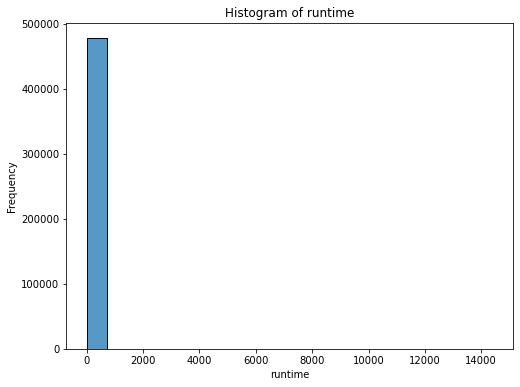

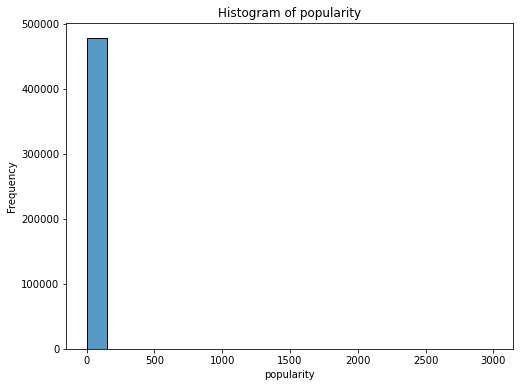

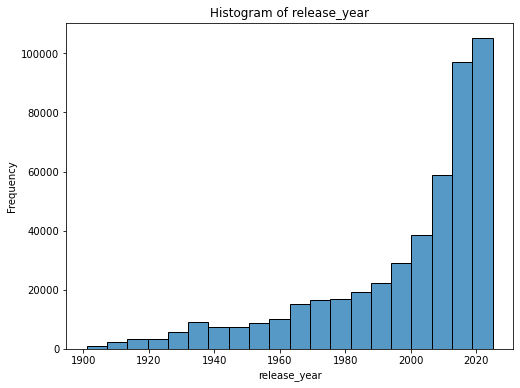

In [34]:
plotHistogram(moviesDF)

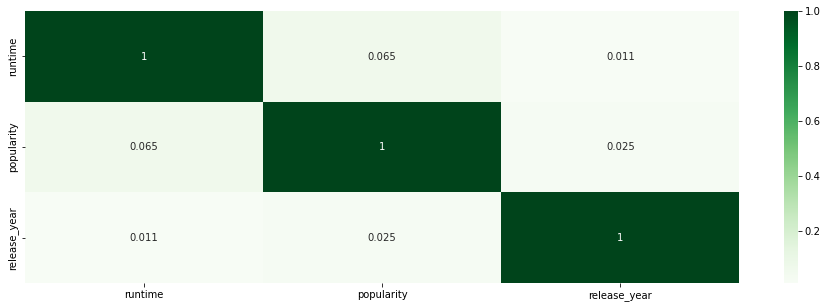

In [35]:
plotCorrelation(moviesDF)

In [47]:
def plotBoxPlot (df):
    for column in numericalColumns:
        tempPanda = df.select(column).toPandas()
        plt.figure(figsize = (8,6))
        sns.boxplot(x = tempPanda[column])
        plt.xlabel(column)
        plt.title(f"Box plot of {column}")
        plt.show()

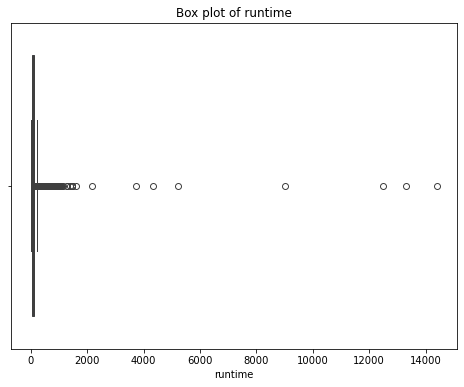

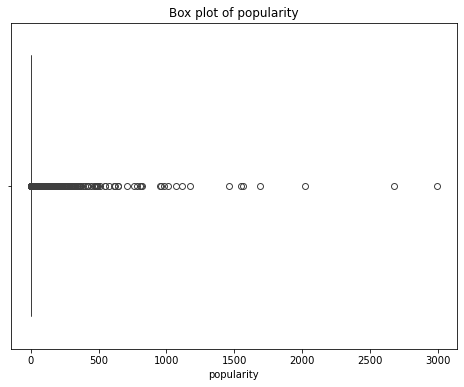

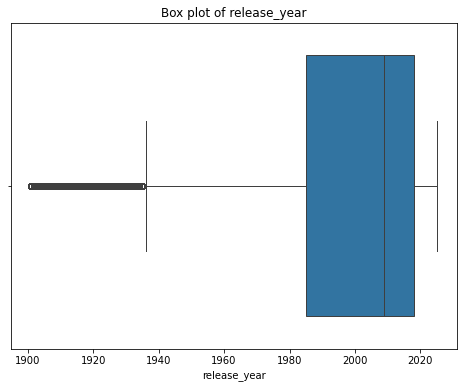

In [48]:
plotBoxPlot (moviesDF)

In [53]:
moviesDF.where("runtime <= 96").count()

363071